# The Human Movement Project 

#### A Machine Learning Approach

In [2]:
#All necessary imports to anazlyse, visualise data, train and test models.

import numpy as np 
import pandas as pd 
from scipy import signal
import matplotlib.pyplot as plt 
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [9]:
#Reading the data files essentially making them into ONE 
df1 = pd.read_csv('daliac/dataset_1.txt', sep=',', header=None)
df2 = pd.read_csv('daliac/dataset_2.txt', sep=',', header=None)  
df3 = pd.read_csv('daliac/dataset_3.txt', sep=',', header=None)  
df4 = pd.read_csv('daliac/dataset_4.txt', sep=',', header=None)  
df5 = pd.read_csv('daliac/dataset_5.txt', sep=',', header=None)  
df6 = pd.read_csv('daliac/dataset_6.txt', sep=',', header=None)  
df7 = pd.read_csv('daliac/dataset_7.txt', sep=',', header=None)  
df8 = pd.read_csv('daliac/dataset_8.txt', sep=',', header=None)  
df9 = pd.read_csv('daliac/dataset_9.txt', sep=',', header=None)  
df10 = pd.read_csv('daliac/dataset_10.txt', sep=',', header=None)  
df11 = pd.read_csv('daliac/dataset_11.txt', sep=',', header=None)  
df12 = pd.read_csv('daliac/dataset_12.txt', sep=',', header=None)  
df13 = pd.read_csv('daliac/dataset_13.txt', sep=',', header=None)  
df14 = pd.read_csv('daliac/dataset_14.txt', sep=',', header=None)  
df15 = pd.read_csv('daliac/dataset_15.txt', sep=',', header=None)  
df16 = pd.read_csv('daliac/dataset_16.txt', sep=',', header=None)  
df17 = pd.read_csv('daliac/dataset_17.txt', sep=',', header=None)  
df18 = pd.read_csv('daliac/dataset_18.txt', sep=',', header=None)  
df19 = pd.read_csv('daliac/dataset_19.txt', sep=',', header=None)  

dataset = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19])

In [10]:
print('The dataset contains %d rows.' % len(dataset)) 
#dataset.head()

The dataset contains 4686842 rows.


### Visualising the data recorded from different Chest Sensors 

In [34]:
def data_visulization():
    #lying valaue in dataset: 
    #Chest Accelermeter Sensors: 6,7,8 
    #Chest Gyroscope sensors: 9,10,11
    
    dataset_lying = dataset[dataset[24] == 2].values
    #Data (column 6 to 8) is used for the chest accelerometers
    plt.plot(dataset_lying[:, 6:9])
    plt.show()
    
    #Data (column 9 to 11) is used for the chest gyroscope
    plt.plot(dataset_lying[:, 9:12])
    plt.show()

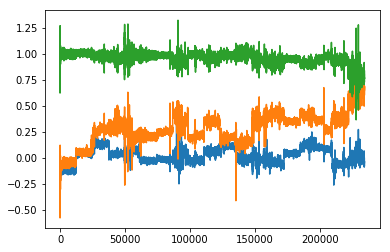

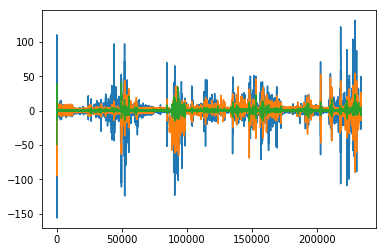

In [35]:
data_visulization()

### Cleaning the selected data and treating it with Noise Reduction

In [54]:
def noise_removing():
    # Butterworth low-pass filter
    b, a = signal.butter(4, 0.04, 'low', analog=False)
    dataset_lying = dataset[dataset[24] == 2].values
    for i in range(3):
        dataset_lying[:,i] = signal.lfilter(b, a, dataset_lying[:, i])
    plt.plot(dataset_lying[15000:20000, 6:9])
    plt.show()
    
    for i in range(3):
        dataset_lying[:,i] = signal.lfilter(b, a, dataset_lying[:, i])
    plt.plot(dataset_lying[15000:20000, 9:12])
    plt.show()

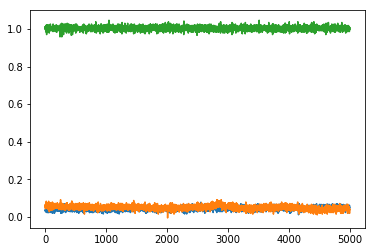

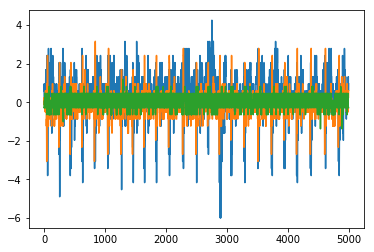

In [55]:
noise_removing()

In [70]:
def feature_engineering_example():
    training = np.empty(shape=(0, 10))
    testing = np.empty(shape=(0, 10))
    # deal with each dataset file
    for i in range(19):
        df = pd.read_csv('daliac/dataset_' + str(i + 1) + '.txt', sep=',', header=None)
        print('deal with dataset ' + str(i + 1))
        for c in range(1, 14):
            activity_data = df[df[24] == c].values
            b, a = signal.butter(4, 0.04, 'low', analog=False)
            for j in range(24):
                activity_data[:, j] = signal.lfilter(b, a, activity_data[:, j])
            
            datat_len = len(activity_data)
            training_len = math.floor(datat_len * 0.8)
            training_data = activity_data[:training_len, :]
            testing_data = activity_data[training_len:, :]

            # data segementation: for time series data, we need to segment the whole time series, and then extract features from each period of time
            # to represent the raw data. In this example code, we define each period of time contains 1000 data points. Each period of time contains 
            # different data points. You may consider overlap segmentation, which means consecutive two segmentation share a part of data points, to 
            # get more feature samples.
            training_sample_number = training_len // 1000 + 1
            testing_sample_number = (datat_len - training_len) // 1000 + 1

            for s in range(training_sample_number):
                if s < training_sample_number - 1:
                    sample_data = training_data[1000*s:1000*(s + 1), :]
                else:
                    sample_data = training_data[1000*s:, :]
                # in this example code, only three accelerometer data in wrist sensor is used to extract three simple features: min, max, and mean value in
                # a period of time. Finally we get 9 features and 1 label to construct feature dataset. You may consider all sensors' data and extract more

                feature_sample = []
                for i in range(3):
                    feature_sample.append(np.min(sample_data[:, i]))
                    feature_sample.append(np.max(sample_data[:, i]))
                    feature_sample.append(np.mean(sample_data[:, i]))
                feature_sample.append(sample_data[0, -1])
                feature_sample = np.array([feature_sample])
                training = np.concatenate((training, feature_sample), axis=0)
            
            for s in range(testing_sample_number):
                if s < training_sample_number - 1:
                    sample_data = testing_data[1000*s:1000*(s + 1), :]
                else:
                    sample_data = testing_data[1000*s:, :]

                feature_sample = []
                for i in range(3):
                    feature_sample.append(np.min(sample_data[:, i]))
                    feature_sample.append(np.max(sample_data[:, i]))
                    feature_sample.append(np.mean(sample_data[:, i]))
                feature_sample.append(sample_data[0, -1])
                feature_sample = np.array([feature_sample])
                testing = np.concatenate((testing, feature_sample), axis=0)

    df_training = pd.DataFrame(training)
    df_testing = pd.DataFrame(testing)
    df_training.to_csv('training_data.csv', index=None, header=None)
    df_testing.to_csv('testing_data.csv', index=None, header=None)